In [1]:
from fastai.vision import *

## Load Data

In [2]:
data_folder = './data/real/fastai'
path = Path('.')

data = ImageDataBunch.from_folder(data_folder, bs=32, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

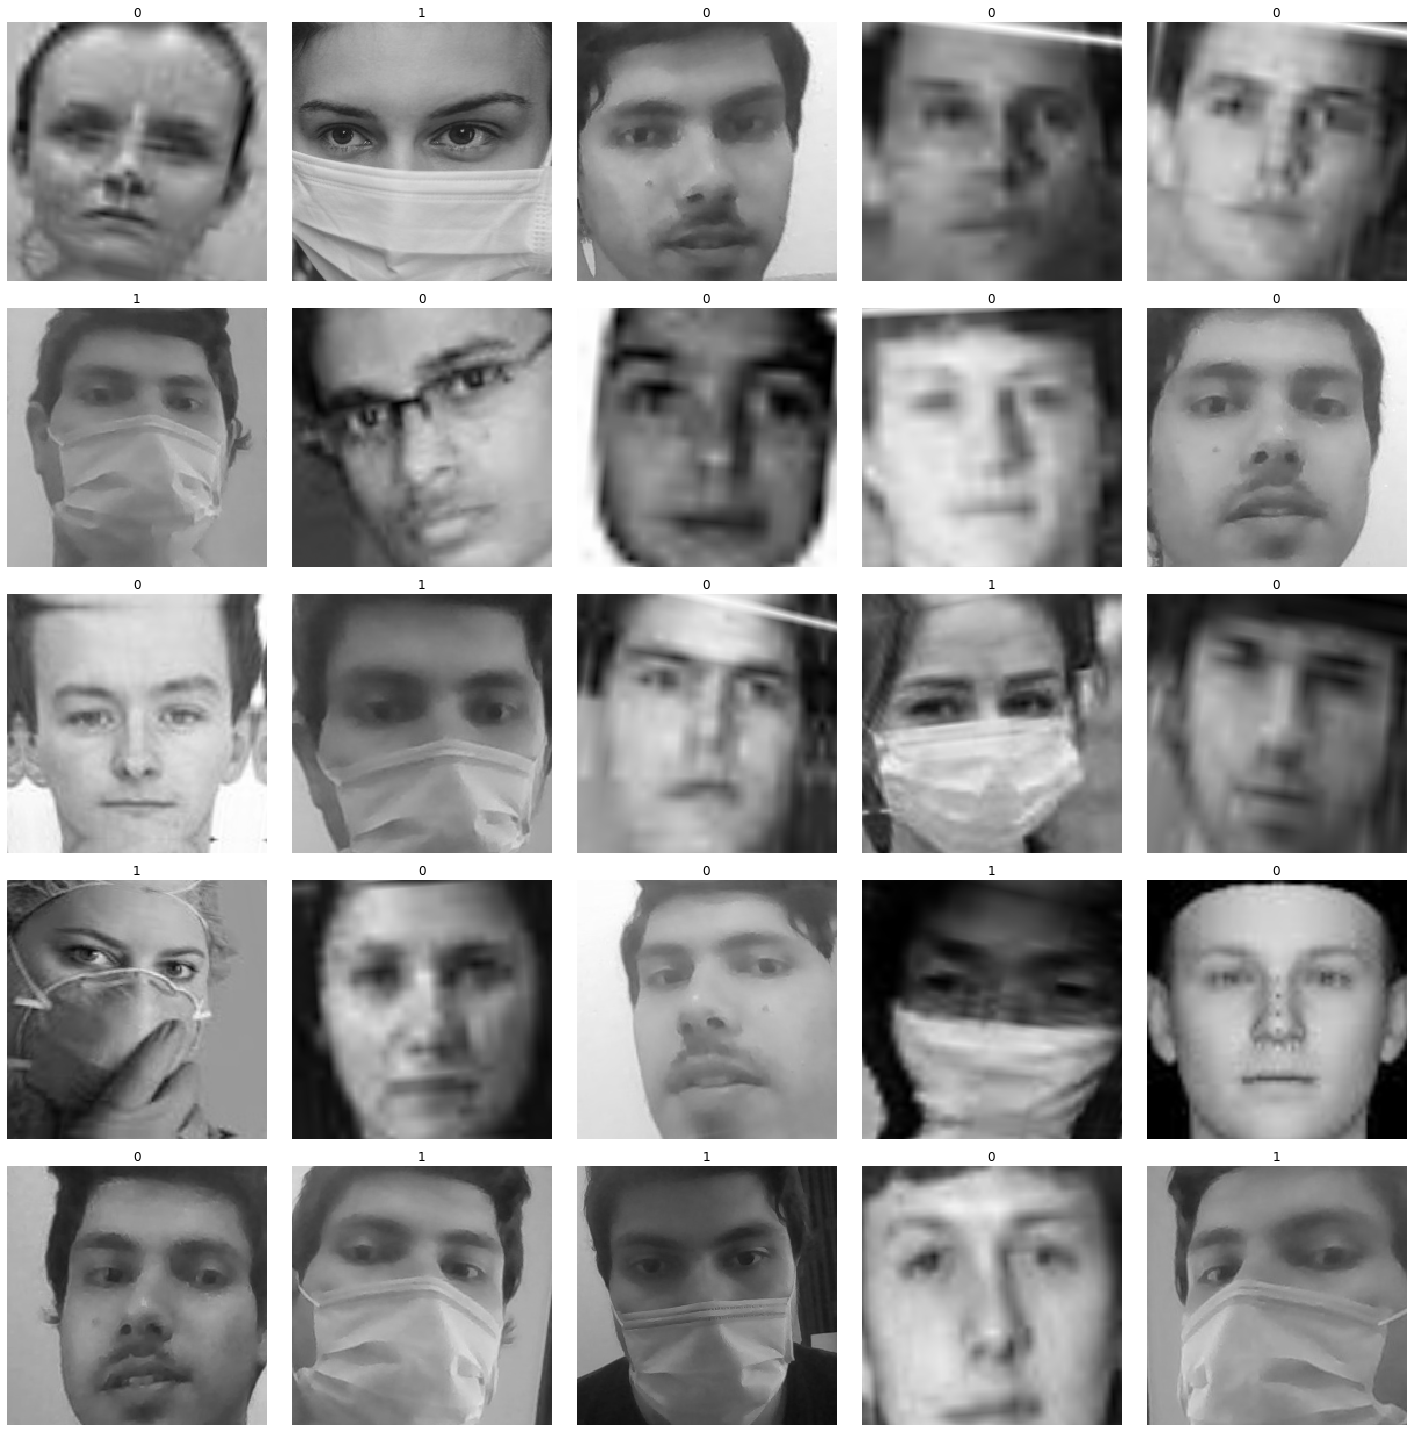

In [3]:
data.show_batch()

## Train pre-trained ResNet

In [8]:
from fastai.metrics import accuracy,fbeta
learner = cnn_learner(data, models.resnet34, pretrained=True, metrics=[accuracy]) #FBeta(average='weighted')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\oeljundi.DIR.000/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:11<00:00, 7.58MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


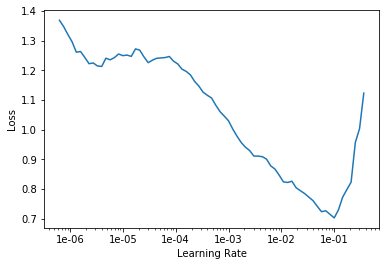

In [5]:
learner.lr_find()
learner.recorder.plot()

In [9]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.841637,0.323973,0.869318,01:12
1,0.554122,0.364303,0.892045,01:11
2,0.382826,0.228757,0.920455,01:10


In [ ]:
# save model checkpoint

In [10]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


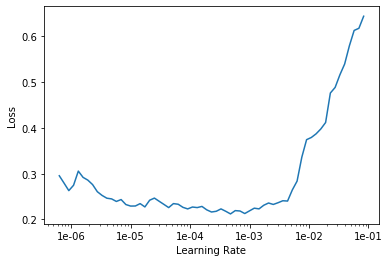

In [11]:
learner.lr_find()
learner.recorder.plot()

In [12]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.223315,0.171435,0.943182,01:12
1,0.185369,0.148889,0.937500,01:12
2,0.169426,0.140370,0.943182,01:11


## Results

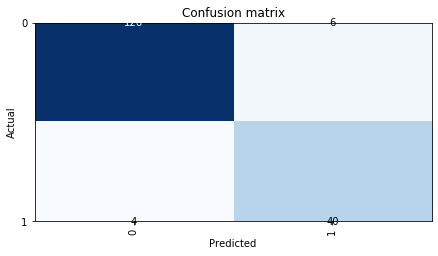

In [13]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [74]:
interp.confusion_matrix()

array([[126,   6],
       [  4,  40]], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


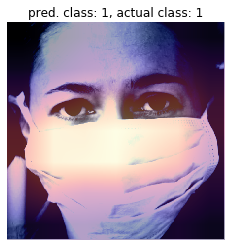

In [72]:
gradcam_image = interp.GradCAM(132,ds_type=DatasetType.Valid)

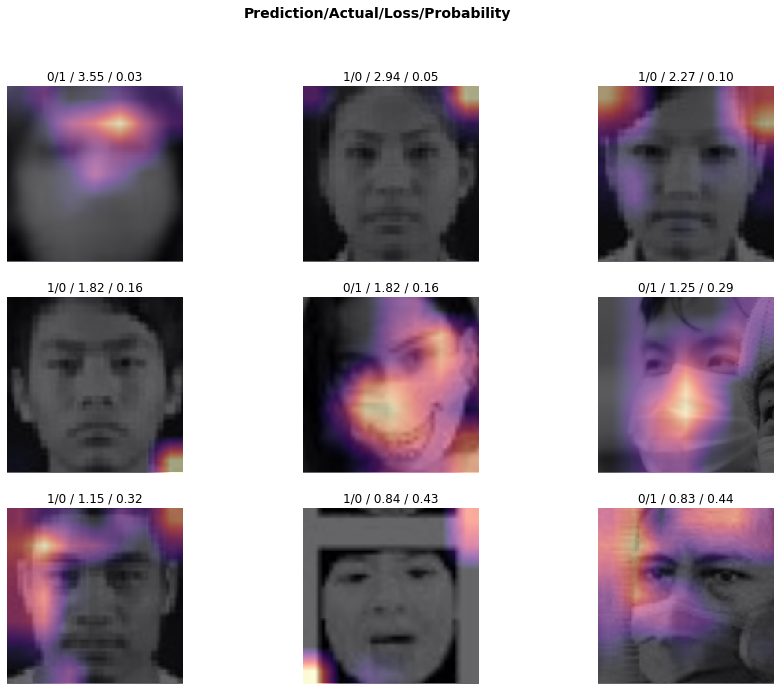

In [46]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)
# prediction, actual, loss, and probability

## save model

In [75]:
learner.save('corona_mask_model_final')

In [76]:
learner.export()

## Predict on new data

In [2]:
learner = load_learner(path='./data/real/fastai', file='export.pkl')

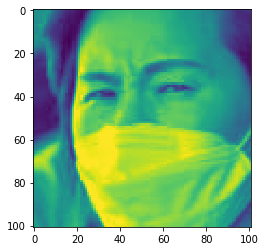

Mask ON :)


In [4]:
import cv2

def predict_on_single_image(model, img_path, face_cascade):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #read image in gray scale
    faces = face_cascade.detectMultiScale(img, 1.2, 5) #detect faces
    (x,y,w,h) = faces[0] #take only first face.. just for testing.. later, take all faces into consideration
    sub_img = img[y:y+h, x:x+w] #take part of image that contains the face only
    plt.imshow(sub_img)
    plt.show()
    cv2.imwrite('to_be_deleted.jpg', sub_img) #save part of image that contains the face only
    img = open_image('to_be_deleted.jpg')
    pred = model.predict(img)
    return pred[0].data.item()


test_img_1 = 'test.jpeg'
test_img_2 = 'test2.png'
face_cascade = cv2.CascadeClassifier('face.xml')

pred = predict_on_single_image(learner, 'extra/test.jpeg', face_cascade)
mask_label = 'No Mask! :(' if pred==0 else 'Mask ON :)'
print(mask_label)
